In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [14]:
#büyük veriyi daha kolay ele alabilmek için tf.data kullanıcaz
#bu veriyi batchlere bölüp daha kolay preprocess etmemizi sağlayacak

IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PotatoPlants",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset) # 2152 / 32(batch size)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy)

#take(1) yöntemi, dataset içerisinden sadece bir parti (batch) veri alır
#image_batch değişkeni, bu partideki görüntüleri (resim verilerini) temsil eder.
#label_batch değişkeni, bu partideki görüntülere ait etiketleri (label'ları) temsil eder yani mesela healthy, late , early gibi

(32, 256, 256, 3)
[0 1 0 1 1 1 0 2 1 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 1]


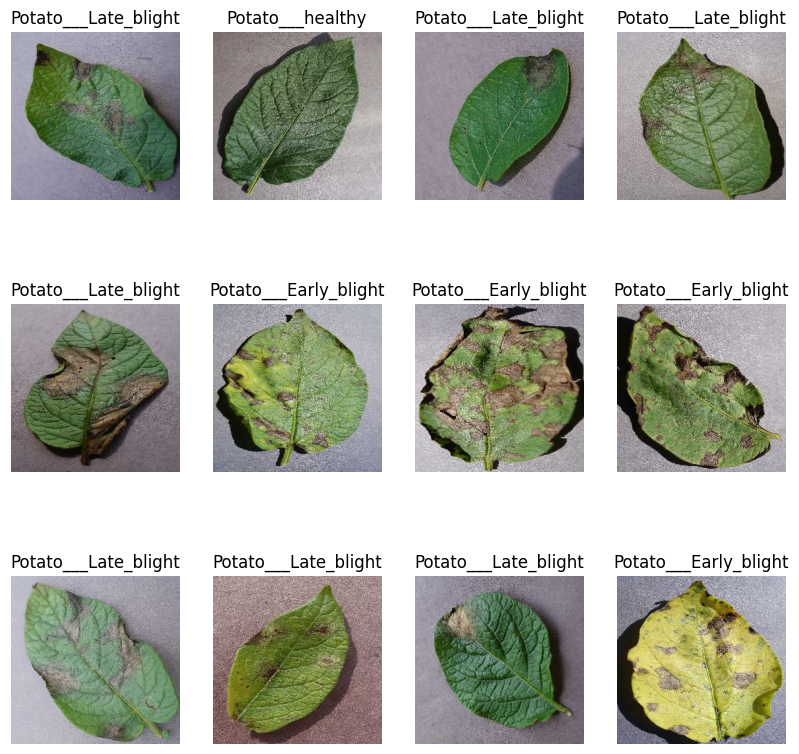

In [13]:
plt.figure(figsize=(10,10))

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) #uint8 rgb değerlerini almasını sağlıyo
        plt.title(class_names[label_batch[i]])
        plt.axis("off")


In [22]:
# 0.8 training, 0.1 validation, 0.1 test olacak. her epoch sonunda 
# validation uygulıycaz. 50 epoch bitip de elimizde final model olunca 
# test edicez

train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [23]:
train_ds = dataset.take(54) #first 54

In [24]:
test_ds = dataset.skip(54) #remaining
len(test_ds)

14

In [25]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [27]:
val_ds = test_ds.take(6)

In [28]:
test_ds= test_ds.skip(6) #8

In [29]:
##bunun hepsini fonk ile yaparsak :

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)

    if shuffle:
        ds= ds.shuffle(shuffle_size, seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [30]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [31]:
len(train_ds)

54

In [32]:
len(val_ds)

6

In [33]:
len(test_ds)

8

In [34]:
#cachede olması tekradan kullanım gerekirse diye memoryde tutulmasını sağlayacak ve performansı arttıracak

train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [35]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [36]:
#data augmentation >> orijinal imagei alıp horizontal flip, contrast, rotation, 
# zoom uygulayıp daha fazla image elde ediyosun ve bu modelin daha iyi öğrenmesini sağlıyor

data_auggmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])